In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
df = pd.read_excel('data/IncidentiModificato.xlsx', index_col='VERBALE')

X = df[['SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]
y = df['Mezzo']

In [3]:
from sklearn.decomposition import PCA
pd.options.mode.chained_assignment = None  # default='warn'

def get_X_pca_totals(dataframe):
    X_pca = dataframe[['SESSO', 'ANNI', 'PESO', 'ALTEZZA','BMI']]

    for parte_corpo in ['Testa', 'Torace', 'Addome', 'Scheletro']:
        pca = PCA(n_components=1).fit_transform(dataframe.filter(regex=parte_corpo+":"))
        X_pca['PCA ' + parte_corpo] = pca
    
    return X_pca

def perturb(n, x):
    if n + x >= 0 and n + x <= 4:
        return n + x
    else:
        return n - x
    

def add_new_elements_pca(df, perturbation_kind="personal_data", error_distrib = None, n_elements=200, n_columns=3):
    assert(perturbation_kind in ['personal_data', 'body_parts', 'both'])
    df_no_totals = df.drop(columns=df.columns[-5:]) #tolgo i totali per ricalcolarli dopo
    dati_persona = ['DATA', 'SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI', 'Mezzo']
    df_dati_persona = df_no_totals[dati_persona]
    df_parti_corpo = df_no_totals.drop(columns=dati_persona)

    if error_distrib:
        x = error_distrib['x']
        px = error_distrib['px']

    count_elements = 0
    
    while len(df_no_totals) < n_elements:
        index = np.random.choice(df_parti_corpo.index)
        new_index = "FAKE_" + str(index) + "_" + str(count_elements)
        count_elements+=1
        
        parti_corpo = df_parti_corpo.loc[index]
        dati_persona = df_dati_persona.loc[index]
        
        if perturbation_kind == "body_parts" or perturbation_kind == "both":
            pert = parti_corpo.sample(n_columns) 

            for (i,e) in zip(pert.index, pert.values):
                perturbation = np.random.choice(x,p=px)
                parti_corpo[i] = perturb(e,perturbation)
        
        if perturbation_kind == "personal_data" or perturbation_kind == "both":
            for (i,e) in zip(dati_persona.index, dati_persona.values):
                if i in ['ANNI', 'PESO', 'ALTEZZA']:
                    perturbation = df[i].std() * np.random.uniform(-0.3,0.3)
                    dati_persona[i] += perturbation
        
            dati_persona['BMI'] = dati_persona['PESO'] / (dati_persona['ALTEZZA'] ** 2) #ricalcolo il BMI
            
        
        new_elem = parti_corpo.append(dati_persona)
        df_no_totals.loc[new_index] = new_elem
        
        df_no_totals = df_no_totals.drop_duplicates()

    X_pca = get_X_pca_totals(df_no_totals)

    return X_pca, df_no_totals['Mezzo']

In [4]:
def get_accuracies(df, params, _range, perturbation_kind): 
    accuracies = {'n_data' : [], 'activation': [], 'hidden layer sizes' : [], 'best score' : []}
    
    X = get_X_pca_totals(df)
    y = df['Mezzo']
    
    X_std = StandardScaler().fit_transform(X)
    
    mlp = MLPClassifier(learning_rate_init=0.001, max_iter=5000, learning_rate="adaptive")
    clf = GridSearchCV(mlp, params, n_jobs=-1, cv=5)
    clf.fit(X_std,y)

    accuracies['n_data'].append(len(y))
    accuracies['activation'].append(clf.best_estimator_.activation)
    accuracies['hidden layer sizes'].append(clf.best_estimator_.hidden_layer_sizes)
    accuracies['best score'].append(clf.best_score_)
    
    error_distrib = {
        'x' : [-2,-1,0,1,2],
        'px' : [.1,.2,.4,.2,.1]
    }   

    for n_data in _range:

        X_os, y_os = add_new_elements_pca(df=df, perturbation_kind=perturbation_kind, error_distrib=error_distrib, n_elements=n_data, n_columns=3)

        X_os_std = StandardScaler().fit_transform(X_os)

        mlp = MLPClassifier(learning_rate_init=0.001, max_iter=5000, learning_rate="adaptive")
        clf = GridSearchCV(mlp, params, n_jobs=-1, cv=5)
        clf.fit(X_os_std,y_os)

        accuracies['n_data'].append(len(y_os))
        accuracies['activation'].append(clf.best_estimator_.activation)
        accuracies['hidden layer sizes'].append(clf.best_estimator_.hidden_layer_sizes)
        accuracies['best score'].append(clf.best_score_)

    return pd.DataFrame(accuracies)

# Perturbazione solo su dati personali

In questo esperimento ho provato a perturbare i dati personali con distribuzione normale (ovvero l'età, il peso e l'altezza, ricalcolando il BMI in base ai nuovi dati) lasciando invariati i dati sulle lesioni del corpo. 

I nuovi dati sono stati ottenuti nel seguente modo: `new = old + std * random(-0.3, 0.3)`

In [5]:
params = {'activation': ['relu', 'logistic', 'tanh'],
          'hidden_layer_sizes' : [(2), (3,3), (5), (6,3), (5,5),(6), (8), (10), (20), (30), (50)]}

_range = [x for x in range(140, 200, 10)] + [x for x in range(200,2000,100)] + [2**e for e in range(11,15)]

%time personal_data_acc = get_accuracies(df, params, _range, perturbation_kind="personal_data")

Wall time: 41min 8s


In [6]:
personal_data_acc

,n_data,activation,hidden layer sizes,best score
0,130,logistic,50,0.715385
1,140,relu,2,0.678571
2,150,tanh,"(5, 5)",0.773333
3,160,tanh,5,0.768750
4,170,relu,30,0.794118
5,180,tanh,50,0.855556
6,190,tanh,50,0.842105
7,200,tanh,20,0.850000
8,300,tanh,50,0.926667
9,400,tanh,30,0.970000


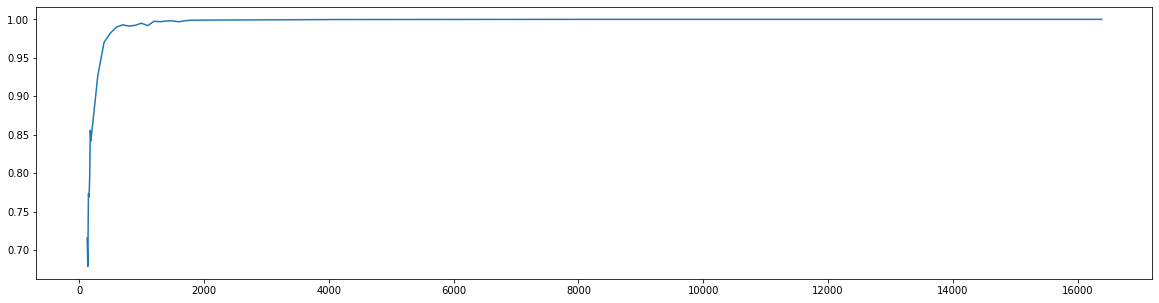

In [7]:
plt.figure(figsize=(20,5))
plt.plot(personal_data_acc['n_data'], personal_data_acc['best score'])
plt.show()

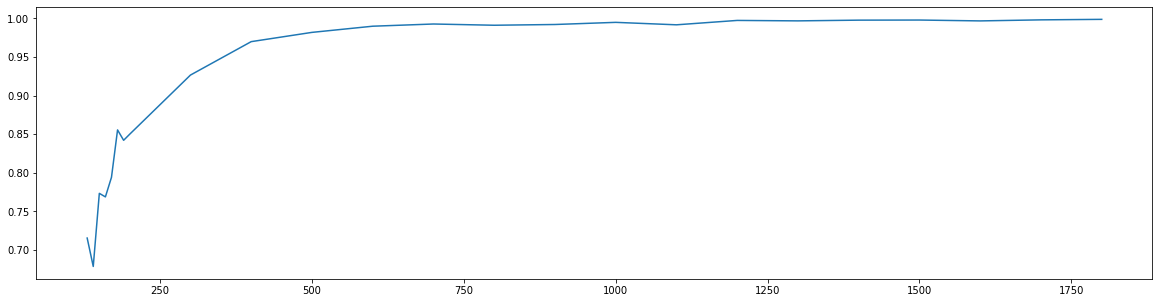

In [8]:
plt.figure(figsize=(20,5))
plt.plot(personal_data_acc['n_data'][:-5], personal_data_acc['best score'][:-5])
plt.show()

# Perturbazione solo su lesioni nel corpo

In questo esperimento ho provato a perturbare le lesioni del corpo (solo 3 colonne su 20) lasciando invariati i dati personali. 

I nuovi dati sono stati ottenuti nel seguente modo: `new = old + disturbo`, dove `disturbo` è `[-2,-1,0,1,2]` con  probabilità `[.1,.2,.4,.2,.1]` (ovviamente restando sempre dentro il range 0,4).

In [9]:
%time body_parts_acc = get_accuracies(df, params, _range, perturbation_kind="body_parts")

Wall time: 46min 21s


In [10]:
body_parts_acc

,n_data,activation,hidden layer sizes,best score
0,130,logistic,5,0.700000
1,140,tanh,5,0.700000
2,150,tanh,20,0.706667
3,160,tanh,10,0.768750
4,170,tanh,50,0.764706
5,180,tanh,50,0.811111
6,190,tanh,30,0.805263
7,200,tanh,50,0.830000
8,300,relu,50,0.883333
9,400,tanh,50,0.945000


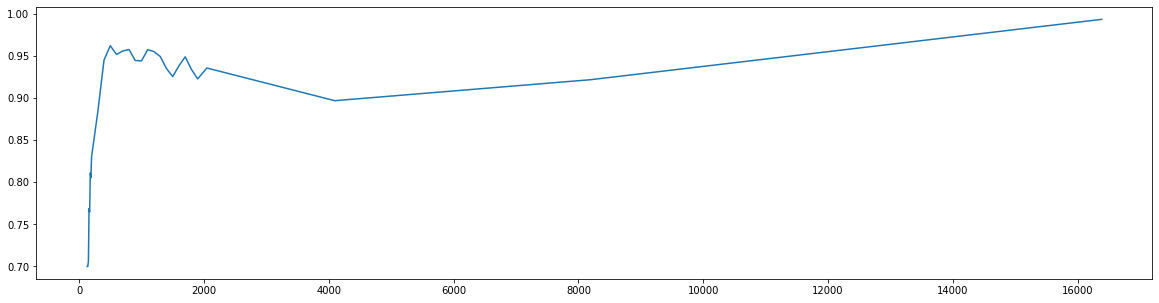

In [11]:
plt.figure(figsize=(20,5))
plt.plot(body_parts_acc['n_data'], body_parts_acc['best score'])
plt.show()

# Perturbazione su tutto

In questo esperimento ho provato ad unire le due cose, mantenendo esattemente gli stessi metodi di perturbazione.

In [12]:
%time both_acc = get_accuracies(df, params, _range, perturbation_kind="both")

Wall time: 41min 36s


In [13]:
both_acc

,n_data,activation,hidden layer sizes,best score
0,130,logistic,10,0.707692
1,140,tanh,10,0.700000
2,150,tanh,20,0.733333
3,160,tanh,20,0.737500
4,170,relu,30,0.770588
5,180,relu,20,0.755556
6,190,tanh,20,0.805263
7,200,tanh,"(6, 3)",0.795000
8,300,tanh,50,0.896667
9,400,relu,50,0.912500


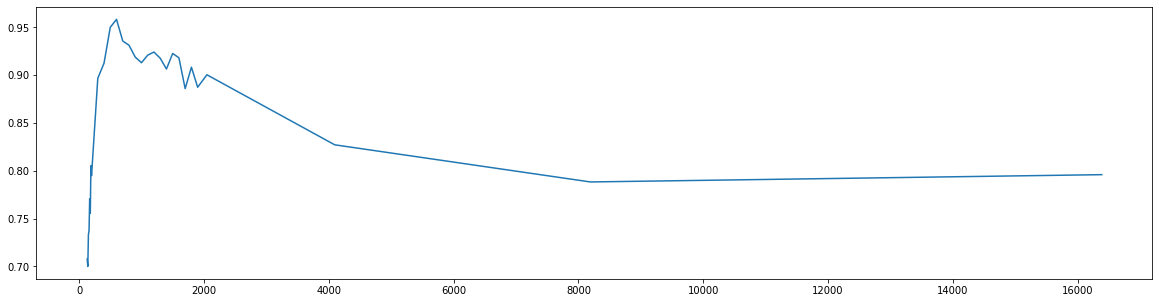

In [14]:
plt.figure(figsize=(20,5))
plt.plot(both_acc['n_data'], both_acc['best score'])
plt.show()

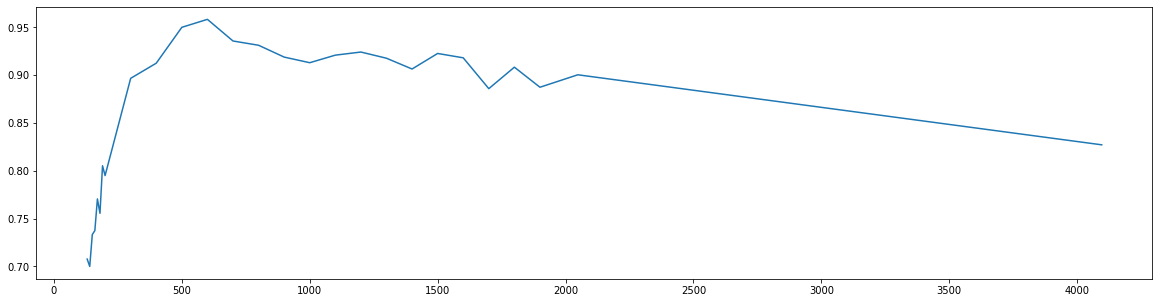

In [15]:
plt.figure(figsize=(20,5))
plt.plot(both_acc['n_data'][:-2], both_acc['best score'][:-2])
plt.show()

# Confronto tra dati aumentati e non

Confronto visivo tra i grafici prodotti dai dati aumentati (prima tabella) e non (seconda tabella). 

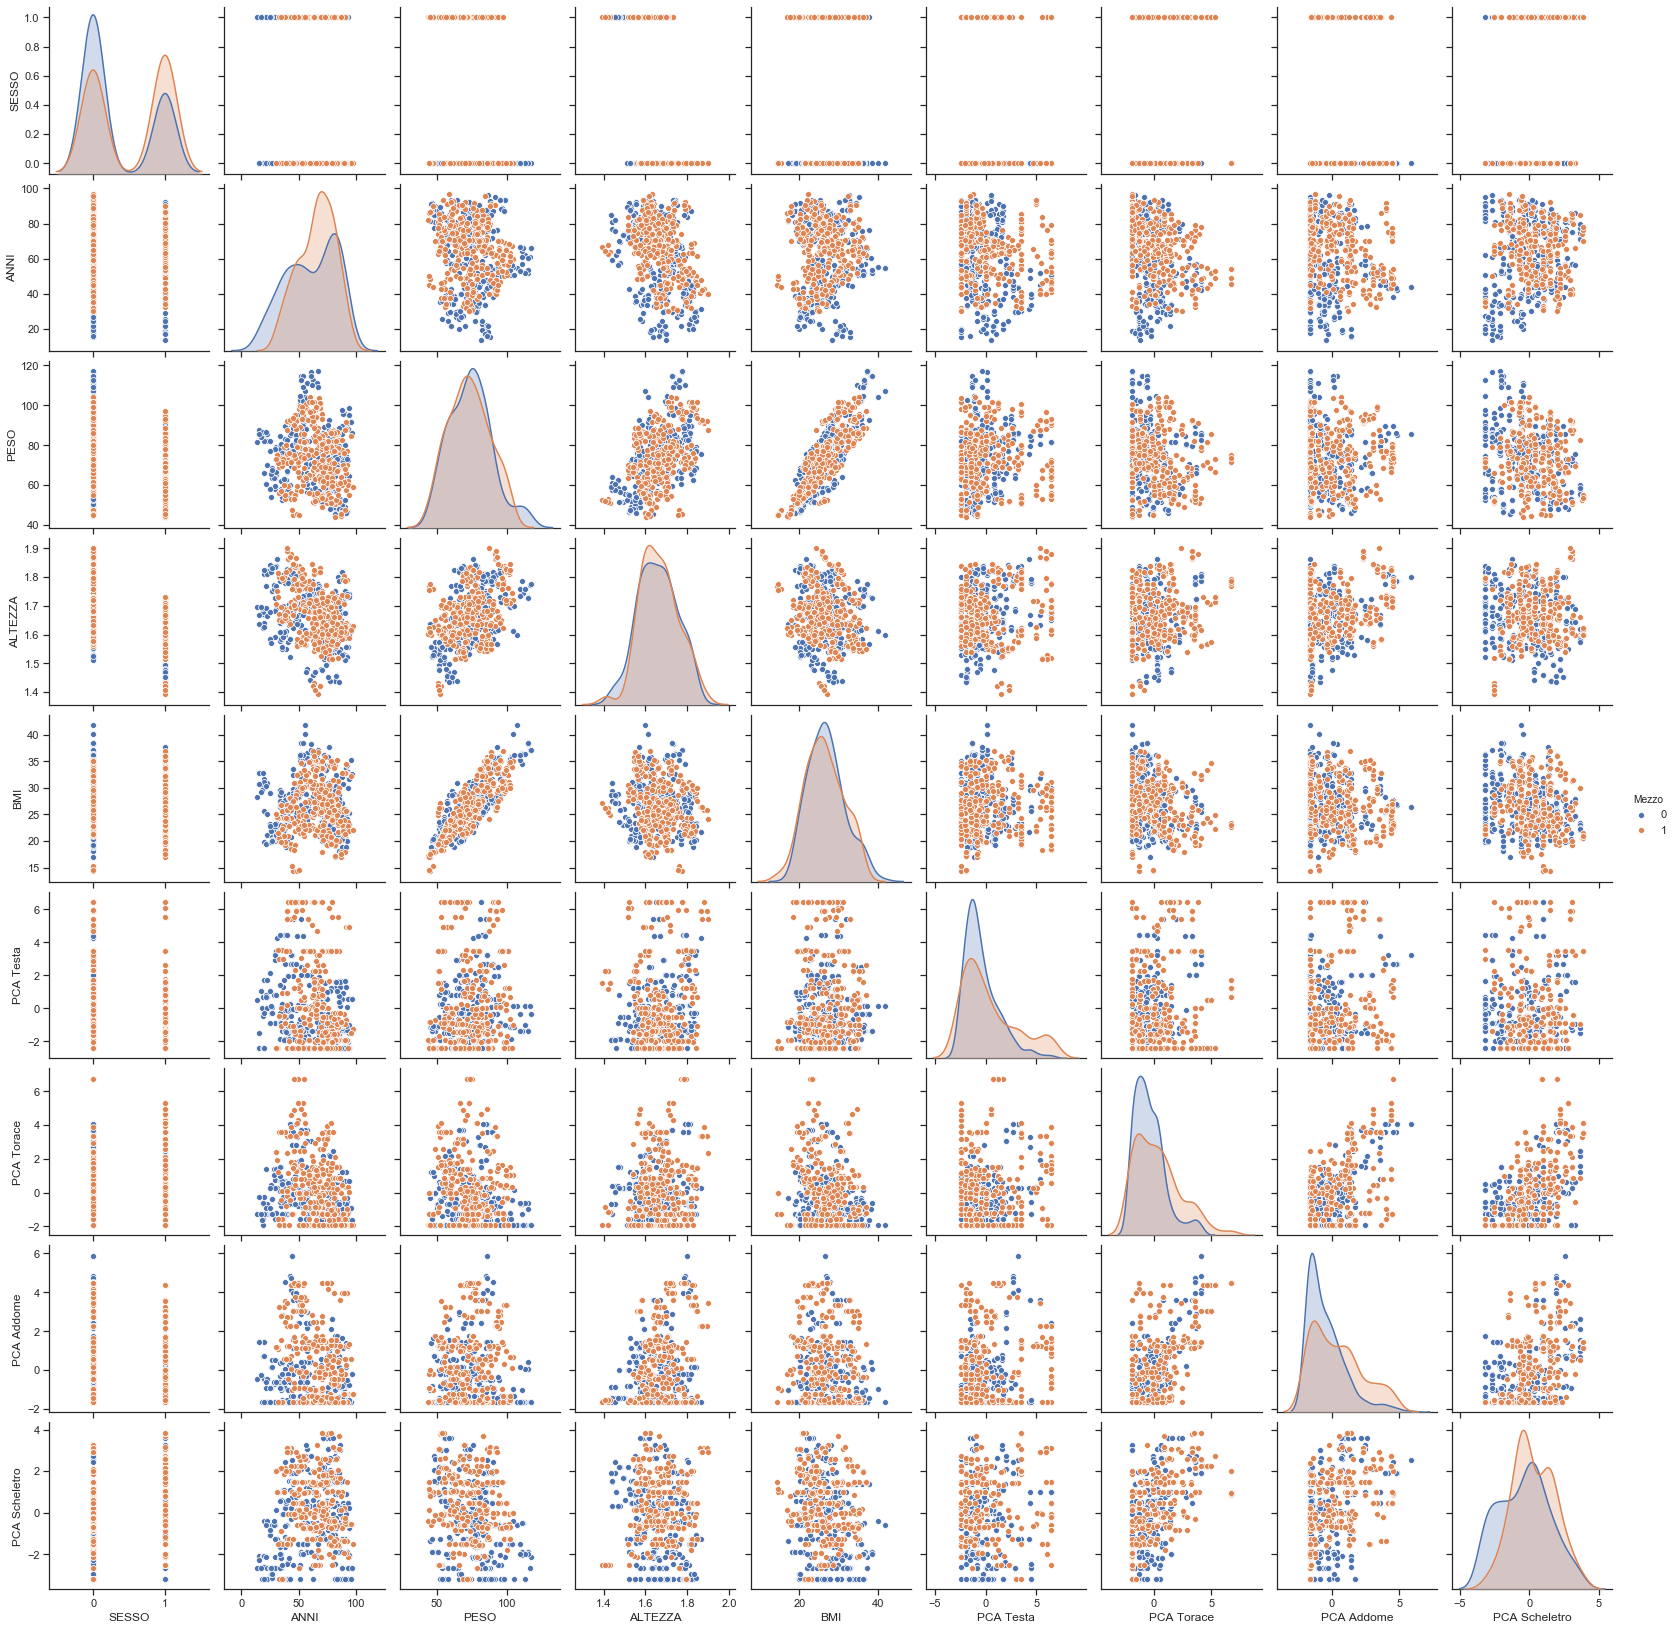

In [17]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)

error_distrib = {
        'x' : [-2,-1,0,1,2],
        'px' : [.1,.2,.4,.2,.1]
    }  

df_pairplot, y_prova = add_new_elements_pca(df=df, perturbation_kind="both", error_distrib = error_distrib, n_elements=600, n_columns=3)
df_pairplot['Mezzo'] = y_prova
sns.pairplot(df_pairplot, hue='Mezzo', diag_kind="kde",x_vars=df_pairplot.columns[:-1], y_vars=df_pairplot.columns[:-1])
plt.show()

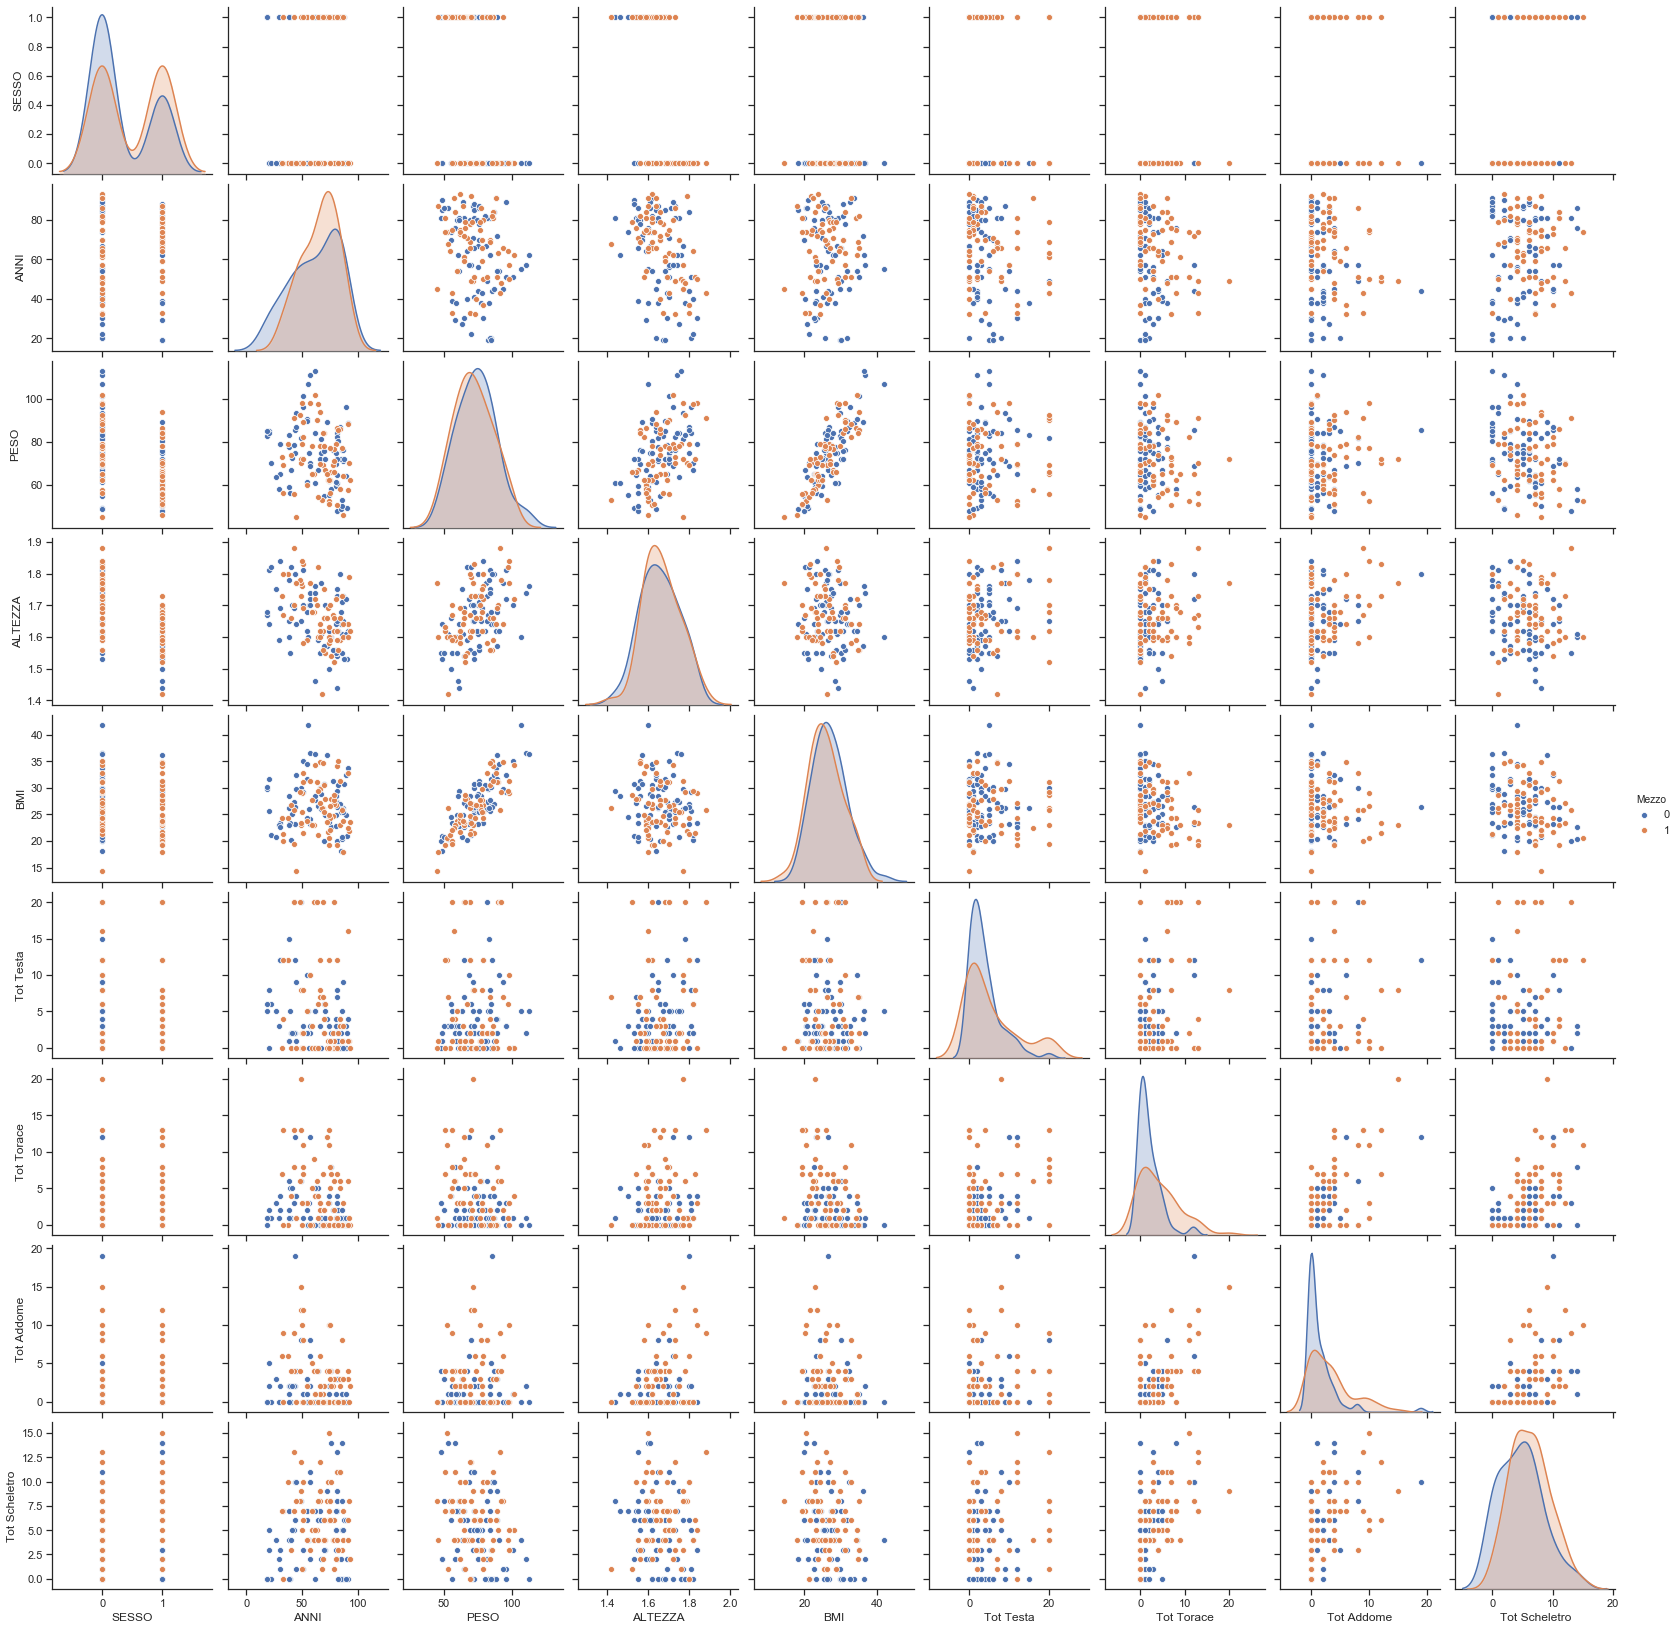

In [18]:
df_pairplot_1 = df[['SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro', 'Mezzo']]
sns.pairplot(df_pairplot_1, hue='Mezzo', diag_kind="kde",x_vars=df_pairplot_1.columns[:-1], y_vars=df_pairplot_1.columns[:-1])
plt.show()